In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

## Paths to the dataset and trained weights

In [2]:
project_path = Path.cwd().parent
input_path = project_path / 'data' / 'SpO2' / 'SpO2_input.csv'
output_path = project_path / 'data' / 'SpO2' / 'SpO2_output.csv'
checkpoint_path = project_path / 'weights' / 'SpO2' / 'square_nn' / 'square_model_scaled_hypnogram_1000epoch.pt'

## Dataset Class

In [3]:
split_ratio = 0.8

class SpO2(Dataset):

    def __init__(self, input_path: Path, output_path: Path, train=True, scale=False):
        x = np.loadtxt(input_path, dtype=int, delimiter=',')
        y = np.loadtxt(output_path, dtype=int, delimiter=',')
        if scale:
            x = (x - np.min(x)) / (np.max(x) - np.min(x))

        split_index = int(x.shape[0] * split_ratio)
        if train:
            self.x = x[:split_index, :]
            self.y = y[:split_index]
        else:
            self.x = x[split_index:, :]
            self.y = y[split_index:]
        assert self.x.shape[0] == self.y.shape[0]
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        self.y = torch.unsqueeze(self.y, dim=1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def print_info(self):
        print(f"{self.x.shape = }")
        print(f"{self.y.shape = }")
        print(f"{torch.max(self.x) = }")
        print(f"{torch.min(self.x) = }")

In [4]:
test_dataset = SpO2(input_path=input_path, 
                    output_path=output_path, 
                    train=False,
                    scale=True)
test_dataset.print_info()
batch_size = 4
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size)

self.x.shape = torch.Size([9217, 300])
self.y.shape = torch.Size([9217, 1])
torch.max(self.x) = tensor(1.)
torch.min(self.x) = tensor(0.)


## The Model

In [5]:
class TorchSquareModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TorchSquareModel, self).__init__()
        self.linear_1 = torch.nn.Linear(input_size, 128)
        self.linear_2 = torch.nn.Linear(128, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear_1(x)
        x = torch.square(x)
        x = self.linear_2(x)
        y_pred = self.sigmoid(x)
        return y_pred

In [6]:
square_nn = TorchSquareModel(300, 1)
checkpoint = torch.load(checkpoint_path)
square_nn.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

## The Inference Function

In [7]:
device = torch.device('cpu')

def inference(model, test_loader):
    test_corrects = 0
    test_total_examples = 0    
    test_accuracies = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            # prepare data
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            # the forward pass
            y_pred = model(x)
            y_pred = y_pred.reshape(y.shape)
            # collect testing results
            test_corrects += torch.sum((y_pred.round() == y))
            test_total_examples += len(y)
    test_acc = test_corrects.item() / test_total_examples
    test_accuracies.append(test_acc)
    print(f"num_test_corrects / test_total_examples = {test_corrects.item()} / {test_total_examples}")
    print(f"testing accuracy = {test_accuracies[-1]:.4f}")

In [9]:
inference(square_nn, test_dataloader)

num_test_corrects / test_total_examples = 8031 / 9217
testing accuracy = 0.8713


## Investigating the above result

### Data

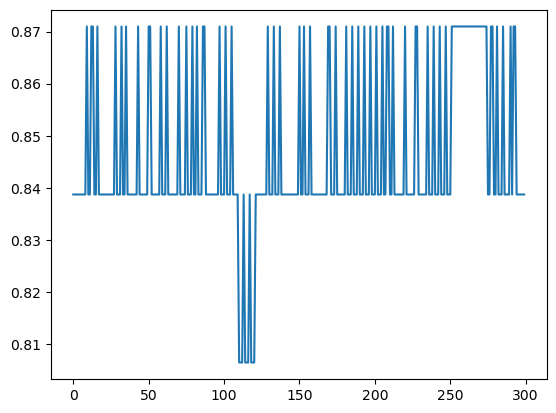

In [36]:
x = test_dataset[-1][0]
plt.plot(x)

### Model